# ScRNA-Seq of human bone marrow cells from Oetjen et al.

Inspired by the work of [Luecken, MD. et al.](https://www.nature.com/articles/s41592-021-01336-8#Sec35)
<br>Code: https://github.com/theislab/scib-reproducibility/tree/main 
<br>
<br>Data from [Freytag, S. et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)
<br>Data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=gse115189  

In [16]:
# Import packages
import scanpy as sc
import pandas as pd
from functions import data_preprocessing as dp

In [17]:
# Path of data
file = '../../../../../data/raw/immune_cells/pbmcs_human/GSE115189/GSM3169075_filtered_gene_bc_matrices_h5.h5'

# Read data
adata = sc.read_10x_h5(filename=file)

adata.var_names_make_unique()

c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\_core\anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\user\Documents\GitHub\Masters_Thesis\MScEnv\lib\site-packages\anndata\utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


In [18]:
print(adata.X.shape)
print(adata)

(3372, 58302)
AnnData object with n_obs × n_vars = 3372 × 58302
    var: 'gene_ids'


In [19]:
adata.var.head()

,gene_ids
DDX11L1,ENSG00000223972
WASH7P,ENSG00000227232
MIR6859-1,ENSG00000278267
MIR1302-2HG,ENSG00000243485
MIR1302-2,ENSG00000284332


In [20]:
adata.X = adata.X.toarray()

## Metadata from [Freytag, S. et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6124389/)

In [21]:
adata.obs["patient"] = "PBMCs_1"
adata.obs["tissue"] = "peripheral blood mononuclear cells"
adata.obs["age"] = "Unknown"
adata.obs["health_condition"] = "healthy"
adata.obs["method"] = "Droplet-based scRNAse"
adata.obs["instrument"] = "Illumina HiSeq 2500"

## Preprocessing

In [22]:
# Add QC metrics to adata
adata = dp.QC().QC_metric_calc(adata)
print(adata.obs)

                    patient                              tissue      age  \
AAACCTGAGCGTGTCC-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
AAACCTGAGTACACCT-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
AAACCTGAGTGTACGG-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
AAACCTGCATCACAAC-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
AAACCTGGTAAATGAC-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
...                     ...                                 ...      ...   
TTTGTCACATCGGAAG-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
TTTGTCAGTACTCAAC-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
TTTGTCAGTAGTACCT-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
TTTGTCAGTGCAACGA-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   
TTTGTCAGTTGAACTC-1  PBMCs_1  peripheral blood mononuclear cells  Unknown   

                   health_condition                 method  \
AAACCTGAGCGTGTCC-1       

In [23]:
qc_adata = dp.QC().QC_filter_outliers(adata,[5,5,5,5])

Number of cells before QC filtering: 3372
Number of cells removed by log_n_genes filtering: 148
Number of cells removed by log_n_counts filtering: 35
Number of cells removed by pct_counts_in_top_20_genes filtering: 37
Number of cells removed by mt_frac filtering: 92
Number of cells post QC filtering: 3131
Number of genes before filtering: 58302
Number of genes after filtering so theres min 20 unique cells per gene: 12431


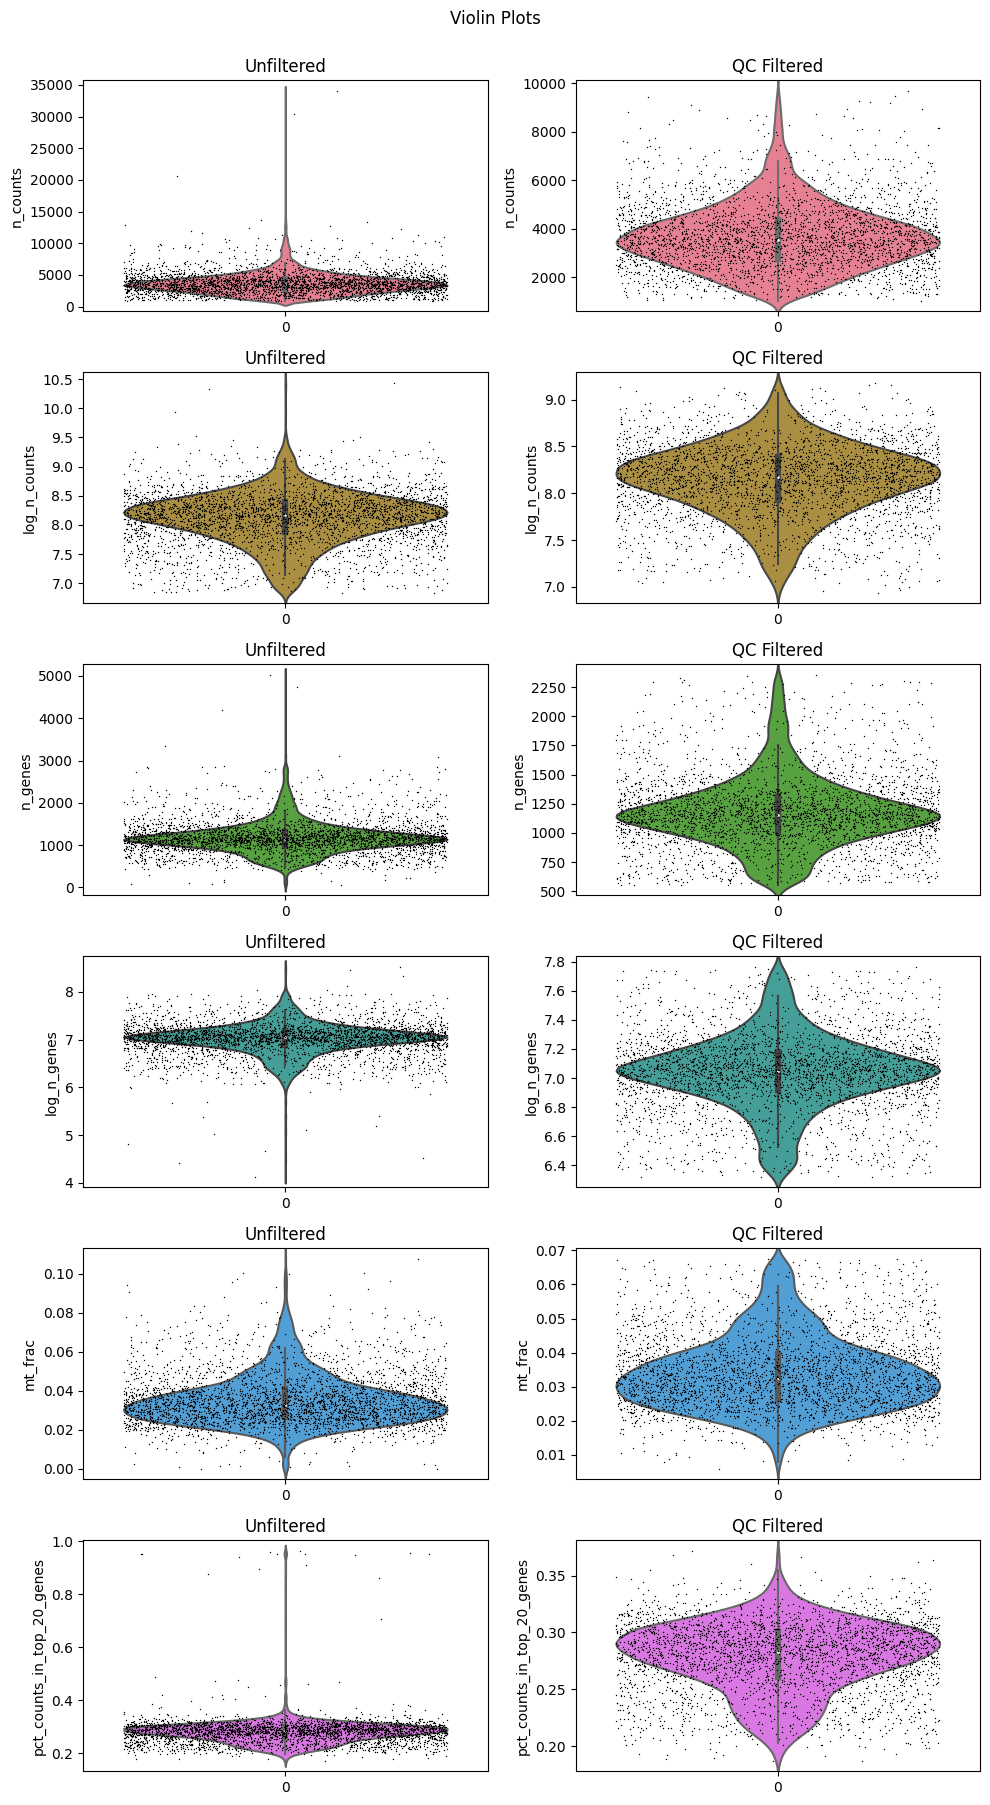

In [24]:
dp.EDA().ViolinJitter([adata, qc_adata], 
                        y_rows=['n_counts','log_n_counts','n_genes','log_n_genes','mt_frac','pct_counts_in_top_20_genes'], 
                        title="Violin Plots",
                        subtitle=["Unfiltered", "QC Filtered"])

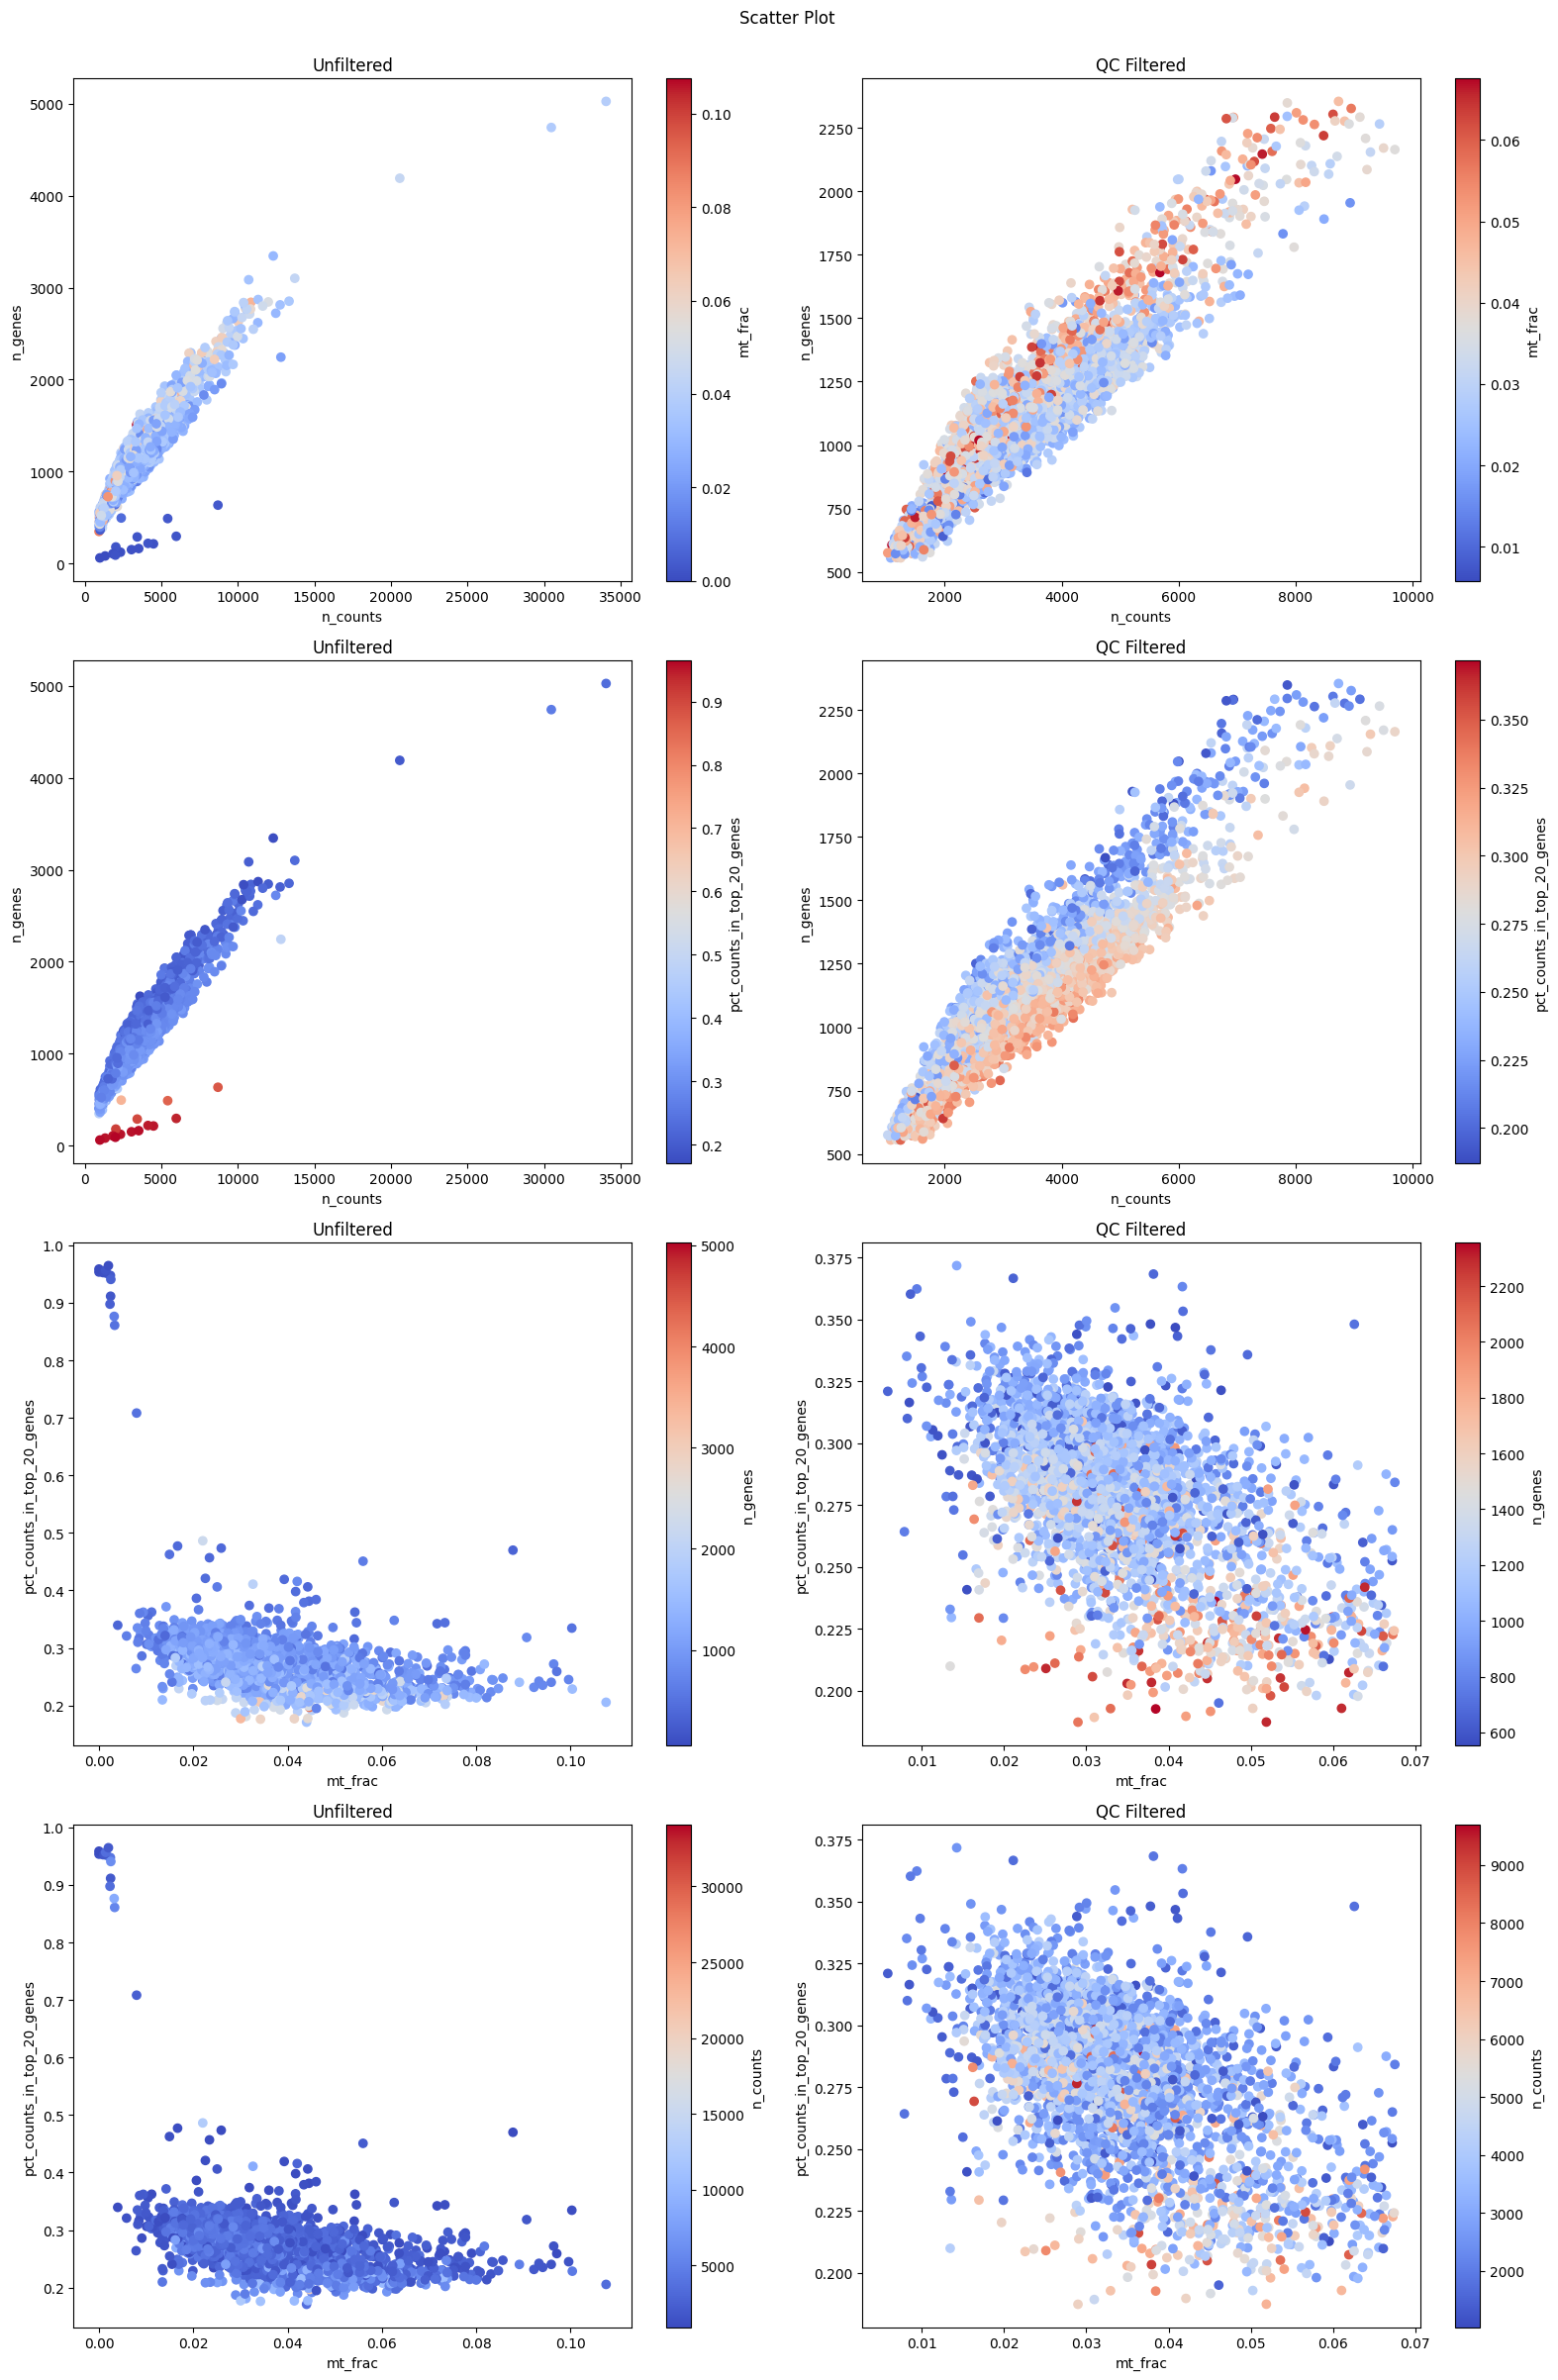

In [25]:
dp.EDA().ScatterForQCMetrics([adata, qc_adata],
                            title="Scatter Plot",
                            subtitle=["Unfiltered", "QC Filtered"])

## Normalize

In [26]:
norm_qc_adata = dp.log1p_normalize(qc_adata)

In [27]:
norm_qc_adata

AnnData object with n_obs × n_vars = 3131 × 12431
    obs: 'patient', 'tissue', 'age', 'health_condition', 'method', 'instrument', 'n_counts', 'log_n_counts', 'n_genes', 'log_n_genes', 'pct_counts_in_top_20_genes', 'mt_frac', 'outlier', 'size_factors'
    var: 'gene_ids', 'n_cells'
    layers: 'counts', 'log1p_counts'

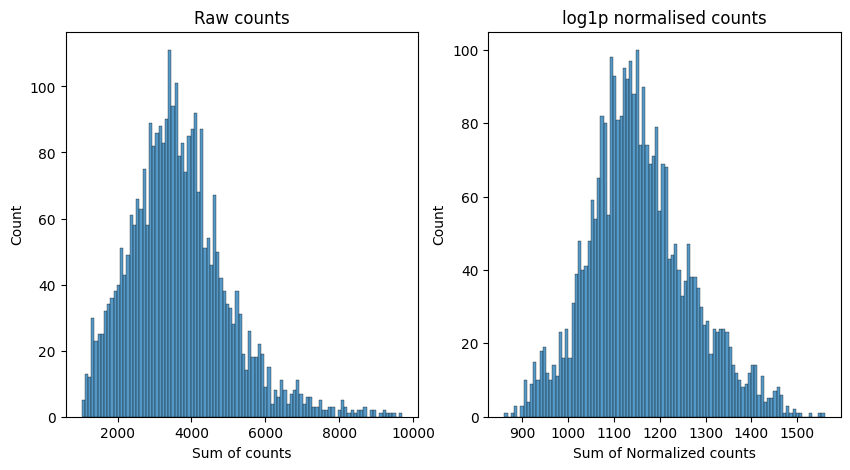

In [28]:
# Visualize counts before and after normalization
dp.EDA().VisualizeNormalization(norm_qc_adata)

In [29]:
# Download normalized count matrix
sc.pp.highly_variable_genes(norm_qc_adata, n_top_genes=4000, flavor="cell_ranger")
HVG_data = norm_qc_adata[:, norm_qc_adata.var["highly_variable"]]
normalized_counts = pd.DataFrame(HVG_data.layers["log1p_counts"])
normalized_counts.index = HVG_data.obs.index.to_list()
normalized_counts.columns = HVG_data.var.index.to_list()
normalized_counts.to_csv("PBMCs_1.csv")
norm_qc_adata.write("PBMCs_1_adata.h5ad")